
# Gaussian Naive Bayes


In [168]:
from sklearn.metrics import recall_score, classification_report


def plot_cmatrix(y_test, y_pred_test):
    confmat = confusion_matrix(y_test, y_pred_test)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Purples, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=10)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    #plt.savefig('ConMatrixNB_fit_thres.png', dpi=600)
    plt.show()
    print(recall_score(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))


# Load data

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,-0.191687,-0.611612,-0.473831,0.819943,1.807022,-0.733750,1.527153,1.243393,0.098037,-0.851704,...,0.81734,1.224544,-0.812739,0.816858,1.528958,-0.998836,-0.498499,0.996715,0.495654,0
1,-0.445728,-0.611612,-0.473831,-0.325946,-0.553397,1.350383,-0.654813,-0.882546,1.367177,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,1.001166,2.006022,-1.003296,-2.017536,0
2,0.231714,-0.611612,-0.473831,0.896336,-0.553397,-1.408028,-0.654813,1.568211,1.099990,-0.249521,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
3,-1.885292,-0.611612,-0.473831,-0.147697,-0.553397,-1.162836,1.527153,0.875027,1.033193,-2.557890,...,-1.22348,-0.816630,-0.812739,0.816858,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
4,-0.530408,-0.611612,-0.473831,-1.650085,-0.553397,-0.978942,-0.654813,0.062720,0.565615,0.352663,...,0.81734,1.224544,-0.812739,-1.224203,-0.654040,1.001166,-0.498499,0.996715,0.495654,0


In [170]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["heart_attack"], axis = 1).values
y = df["heart_attack"].values.astype(np.int8)

print(X.shape)
print(y.shape)
print(f"Dataset: {X.shape}  |  positives {(y==1).sum()}")

# Train-test split on the sampled data (BEFORE preprocessing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=1
)


(127030, 33)
(127030,)
Dataset: (127030, 33)  |  positives 63501


# Cross Validation

In [171]:
# Train on data. No parameters to adjust
from sklearn.naive_bayes import GaussianNB       ### Because continuous data
from sklearn.model_selection import (
    StratifiedKFold, 
    cross_val_score, 
    train_test_split
)
import sklearn.neighbors as nb

# OBS: deleted 'random_state' parameter since its use is no longer needed
cv = StratifiedKFold(
    n_splits = 10,
) 

gnb = GaussianNB()
cv_scores = cross_val_score(
    gnb,
    X = X_train,
    y = y_train,
    cv = cv
)
print("Scores:", cv_scores)
print("Mean score:", np.mean(cv_scores))  # Mean score of the executions


Scores: [0.80982368 0.80321159 0.79927582 0.80163728 0.80305416 0.8060148
 0.81042356 0.80774681 0.80475516 0.8031806 ]
Mean score: 0.8049123444730139


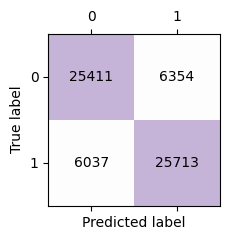

0.8098582677165355
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     31765
           1       0.80      0.81      0.81     31750

    accuracy                           0.80     63515
   macro avg       0.80      0.80      0.80     63515
weighted avg       0.80      0.80      0.80     63515



In [172]:
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score, confusion_matrix

predicted = cross_val_predict(
    estimator = GaussianNB(), 
    X = X_train,
    y = y_train,
    cv = cv
)  

plot_cmatrix(y_train, predicted)


***
## Adjusting probability threshold

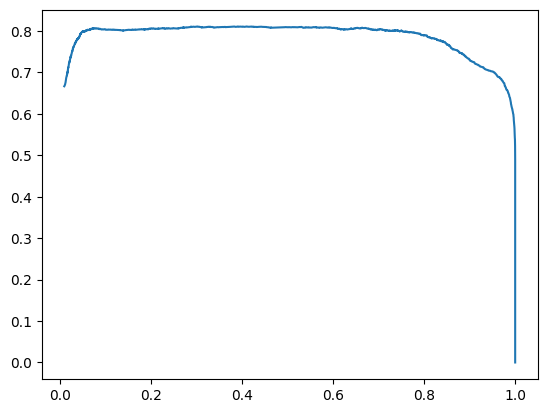

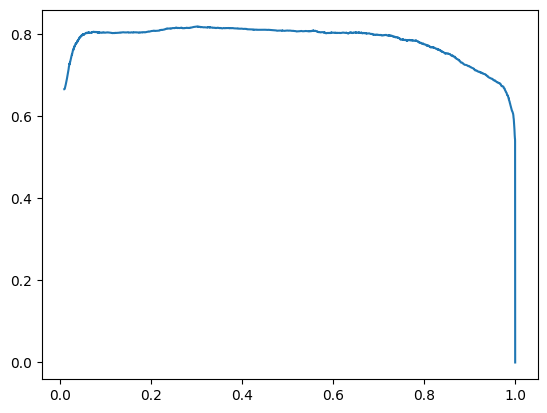

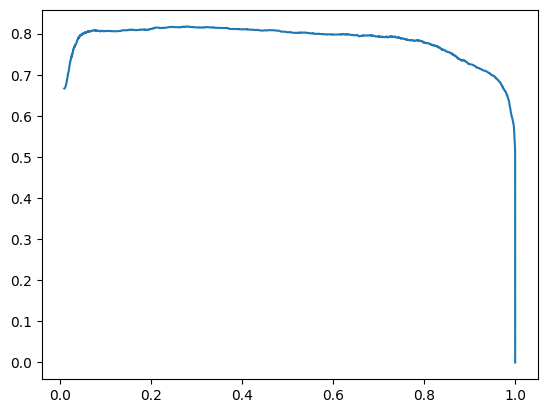

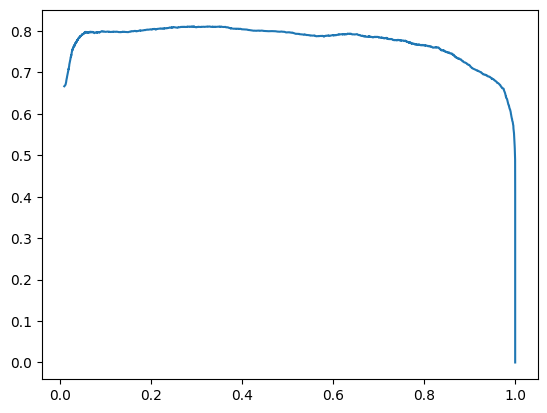

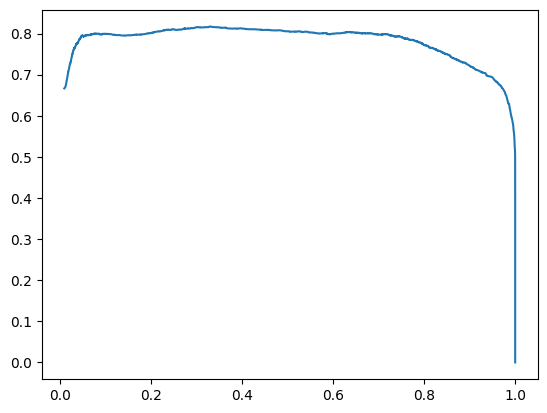

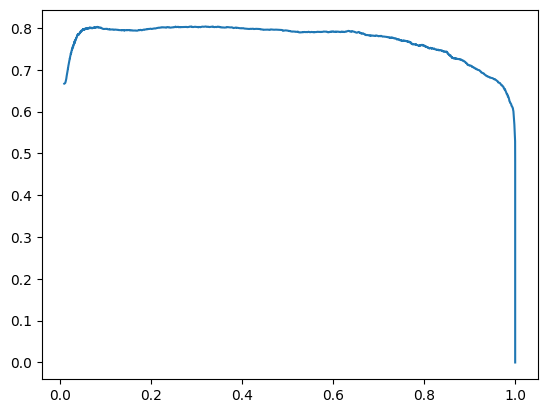

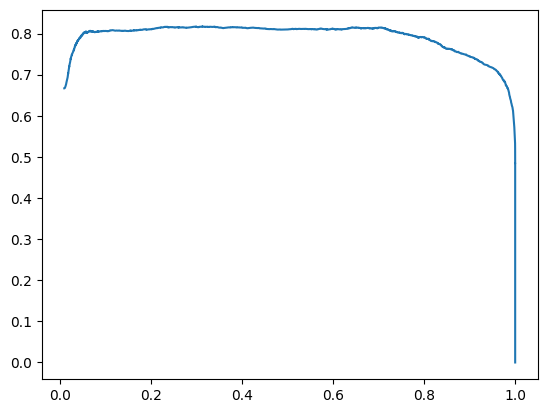

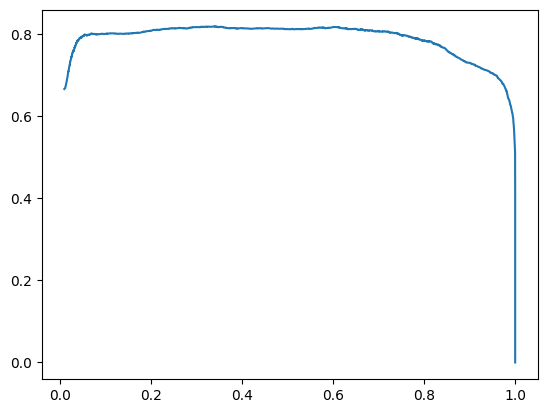

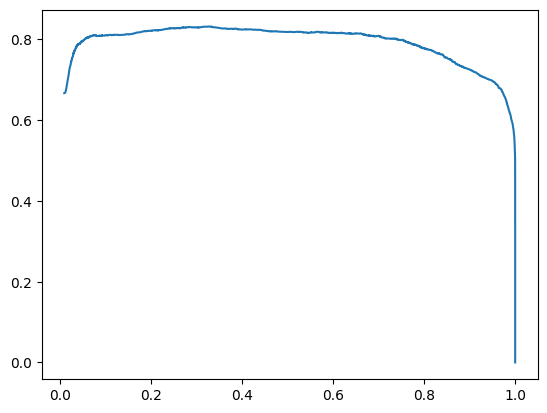

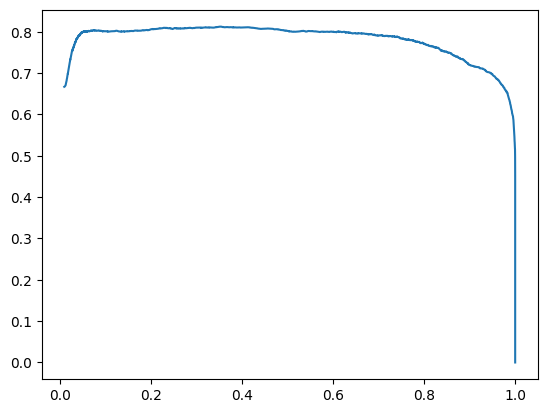

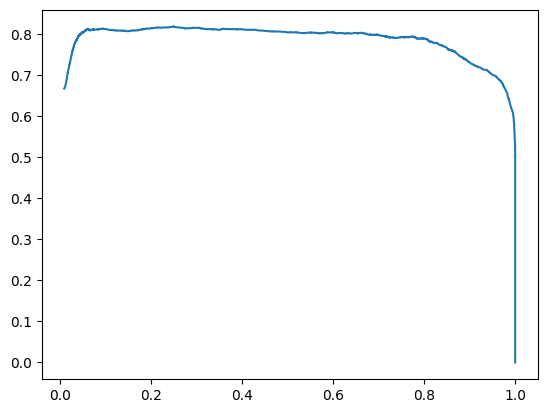

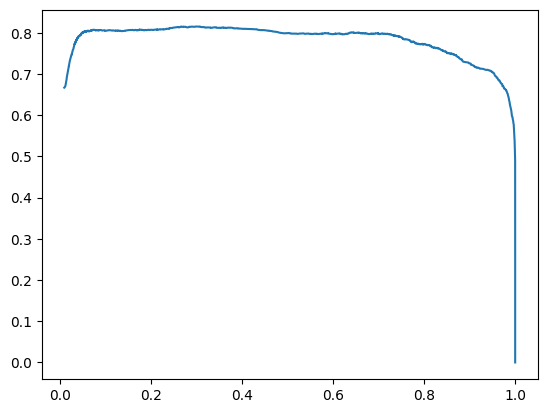

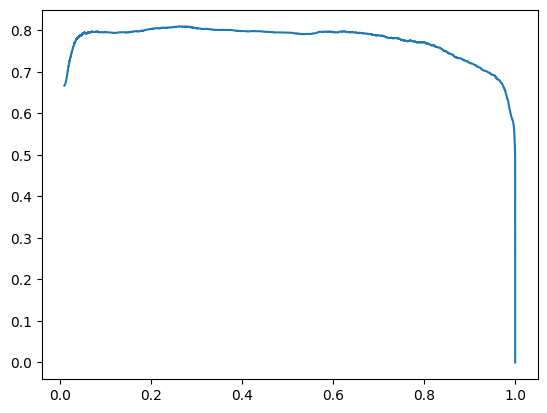

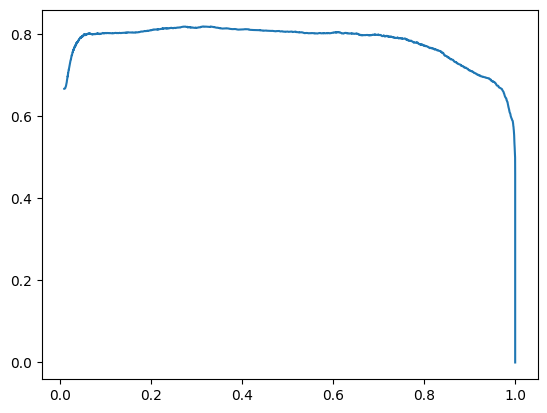

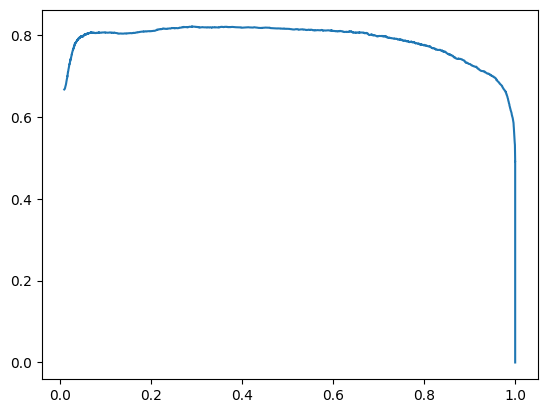

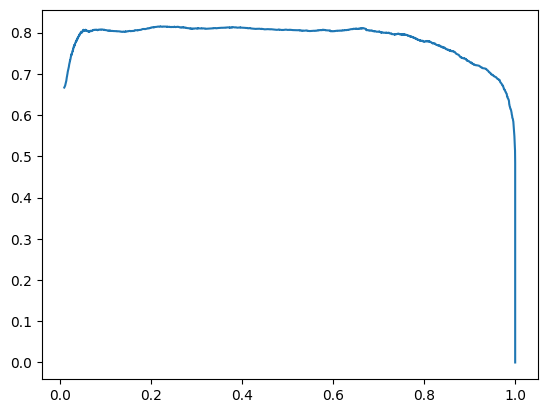

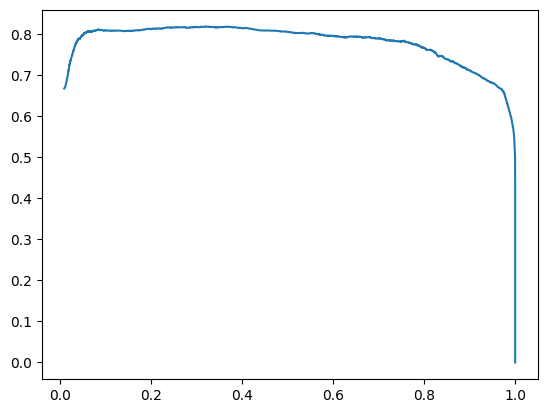

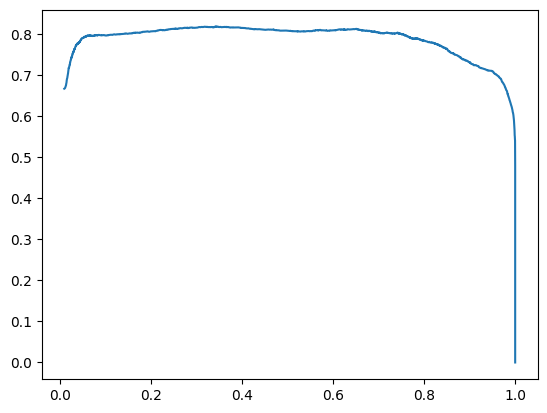

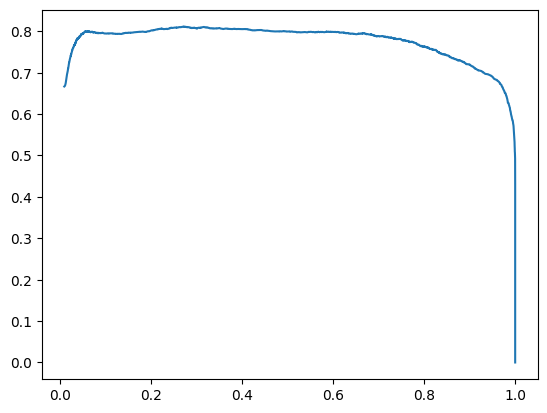

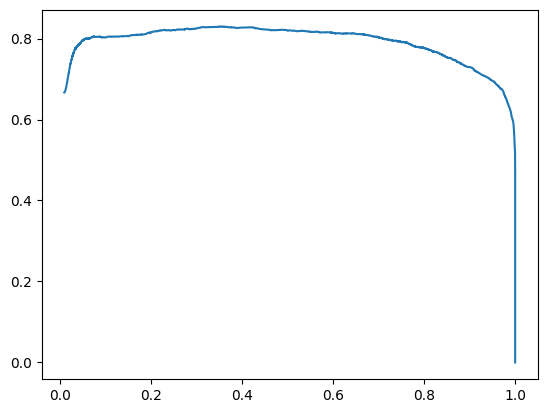

Selected threshold in 20-fold cross validation: 0.309999


In [173]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def filterp(th,ProbClass1):
    """Given a threshold "th" and a set of probabilities of belonging to class 1 "ProbClass1", 
    return predictions.""" 
    y = np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf = GaussianNB()
lth=[]

# We do a 20-fold cross-validation with 10 iterations
kf = StratifiedKFold(
    n_splits = 20, 
    shuffle = True, 
    random_state = 42
)

# Now we compute the threshold by iterating the data we have
for train_index, test_index in kf.split(X_train, y_train):
    # Use X_train instead of X
    X_train2, X_test2 = X_train[train_index], X_train[test_index]
    y_train2, y_test2 = y_train[train_index], y_train[test_index]
    
    clf.fit(X_train2, y_train2)
    probs = clf.predict_proba(X_test2)
    ProbClass1 = probs[:,1]  # This should work now as GaussianNB always returns probabilities for both classes
    
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold)
    res = np.array([[th,f1_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])
    
    # Uncomment the following lines if you want to plot at each iteration how f1-score
    # evolves increasing the threshold 
    plt.plot(res[:,0],res[:,1])
    plt.show()

    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 20 iterations
threshold = np.mean(lth)
print(f"Selected threshold in 20-fold cross validation: {np.round(threshold, 6)}")

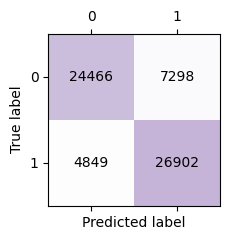

0.8472804006173034
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     31764
           1       0.79      0.85      0.82     31751

    accuracy                           0.81     63515
   macro avg       0.81      0.81      0.81     63515
weighted avg       0.81      0.81      0.81     63515



In [174]:
# Train a classifier with the whole training data 
clf = GaussianNB()
clf.fit(X_train, y_train)

# Obtain probabilities for data on test set
probs = clf.predict_proba(X_test)

# Generate predictions using probabilities and threshold found on 10 folds cross-validation
prediction = filterp(threshold,probs[:,1])

plot_cmatrix(y_test, prediction)


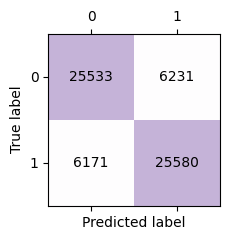

0.8056439167270322
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     31764
           1       0.80      0.81      0.80     31751

    accuracy                           0.80     63515
   macro avg       0.80      0.80      0.80     63515
weighted avg       0.80      0.80      0.80     63515



In [175]:
clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

plot_cmatrix(y_test, prediction)


In [176]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, probs[:, 1], average="macro")
roc_auc

np.float64(0.8998154036248823)

ROC-AUC = 0.900


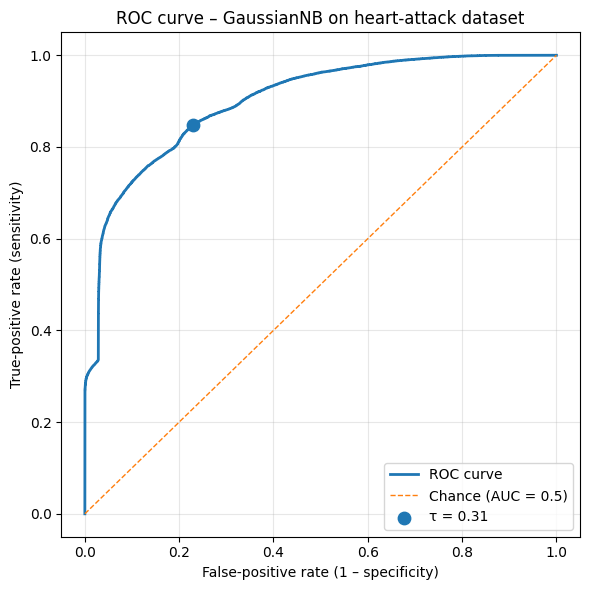

In [178]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ---------- compute ROC points & AUC ------------------------------------
fpr, tpr, thresh = roc_curve(y_test, probs[:, 1])
auc = roc_auc_score(y_test, probs[:, 1])
print(f"ROC-AUC = {auc:.3f}")

# ---------- find coords for τ ≈ 0.31 -----------------------------------
# thresh is sorted high→low; pick the first point whose threshold is within ±0.001 of 0.31
tau = 0.31
idx = np.where((thresh >= tau - 1e-3) & (thresh <= tau + 1e-3))[0][0]
fpr_tau, tpr_tau = fpr[idx], tpr[idx]

# ---------- plot --------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label="ROC curve")
plt.plot([0, 1], [0, 1], ls="--", lw=1, label="Chance (AUC = 0.5)")

# highlight the chosen operating point
plt.scatter(fpr_tau, tpr_tau, s=80, marker="o", label=f"τ = {tau:.2f}")

plt.title("ROC curve – GaussianNB on heart-attack dataset")
plt.xlabel("False-positive rate (1 – specificity)")
plt.ylabel("True-positive rate (sensitivity)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
